# Reproducing graphs and measurements from the VoteAgain paper

This notebook reproduces the performance graphs and numbers used in the paper.

## Setup
We first input some packages

In [2]:
import copy
import csv
import math
import numpy
import statistics

import matplotlib.pyplot as plt

And set up matplotlib.

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', size=12)
#plt.rc('figure', figsize=(5.5,5))

## Simple measurements

We benchmarked the cost of a single P256 group operation on the same machine that was used to run the other experiments.

In [4]:
GROUP_OPERATION_TIME = 47.556254e-6

## Utility functions
We define two utility functions to parse the CSV files output by the various scripts, and to compute statistics on them

**TODO**: documentation of `compute_stats` is not completely up to date

In [5]:
def parse_csv(filename):
    """
    WARNING - WARNING -> See below
    The content of the file as:

    Foo, Bar, Baz
      1,   3,   5
      2,   4,   6

    becomes:

    {'Foo': [1,2], 'Bar': [3,4], 'Baz': [5,6]}
    
    :param filename: Name of the CSV file.
    :return: The content of the CSV file as a dict.
    """
    content = {}

    with open(filename, newline='') as f:
        reader = csv.reader(f, delimiter=',')

        # Retrieve the titles and set them as keys.
        titles = reader.__next__()
        for title in titles:
            content[title] = []

        for row in reader:
            # Only the lines which does not contains the titles are considered.
            if row[0] not in content.keys():
                for index, item in enumerate(row):
                    content[titles[index]].append(float(item))

    return content

In [6]:
def compute_stats(parsed_csv, x_vars):
    """
    Compute statistics for buckets of data.
    in:
    {
      'Foo': [1, 1, 2, 2],
      'Bar': [1, 2, 3, 4]
    }
    
    out:
    {
      'measurements': [1, 2],
      'Bar':
      {
        'means': [1.5, 3.5],
        'sems': [0.5, 0.5]
      }
    }
    """
    # Convenience function, convert x_vars into list if it is a string
    if isinstance(x_vars, str):
        x_vars = [x_vars]
    
    # The indexes for each set of values.
    index_same_values = {}
    for index, value in enumerate(zip(*[parsed_csv[x_var] for x_var in x_vars])):
        index_same_values.setdefault(value, []).append(index)

    fields_to_parse = set(parsed_csv.keys()) - set(x_vars)
    output = {"measurements": list(index_same_values.keys())}

    for key in fields_to_parse:
        raw_values = parsed_csv[key]
        means = []
        sems = []
        for indexes in index_same_values.values():
            bucket = [raw_values[i] for i in indexes]

            mean = statistics.mean(bucket)
            sem = statistics.stdev(bucket) / math.sqrt(len(bucket))
            
            means.append(mean)
            sems.append(sem)

        output[key] = {'means': means, 'sems': sems}
    return output

The following function creates a quick plot of the imported data.

In [7]:
def show_plot(values, titles, x_var):
    """
    Display a nice plot for a set of data.
    :param values: values to be plotted as a dict.
    :param titles: list of titles in order.
    :param x_val: values to use as the x.
    """
    fig, ax = plt.subplots()

    colors = ('blue', 'red', 'green', 'cyan', 'magenta', 'yellow')
    col = iter(colors)

    x = values["measurements"]

    for title in titles:
        y = values[title]['means']
        yerr = values[title]['sems']
        ax.errorbar(x, y, yerr=yerr, label=title.replace('_', ' '), color=next(col), fmt='.-')

    ax.set_ylabel('Time [s]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(x_var.replace('_', ' '))
    ax.legend(loc=0)
    # ax.xlim(1e4, 1e6)

    plt.show()

## Plotting performance of VoteAgain

We first import the data from the experiments.

In [8]:
full_filter_raw = parse_csv('../data/filter/full_filter.csv')
full_filter_ver_raw = parse_csv('../data/filter/full_filter_ver.csv')

full_filter = compute_stats(full_filter_raw, 'Nr_Voters')
full_filter_ver = compute_stats(full_filter_ver_raw, 'Nr_Voters')

We plot a summary of the results. These figures are not included in the paper.

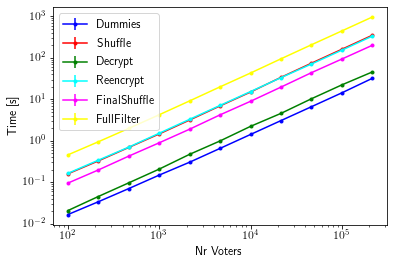

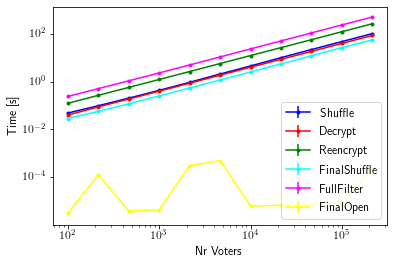

In [9]:
titles = ['Shuffle', 'Decrypt' , 'Reencrypt' , 'FinalShuffle', 'FullFilter']
show_plot(full_filter, ["Dummies"] + titles , 'Nr_Voters')
show_plot(full_filter_ver, titles + ['FinalOpen'], 'Nr_Voters')

We compute an lowerbound for Achenbach et al.'s protocol based on a count of the number of group operations and a measurement of the time it takes to perform such a group operations.

In [10]:
filter_achenbach = []
for voters in full_filter["measurements"]:
    # voters is tuple with only a single element
    voters = voters[0]
    
    square = voters * voters

    filter_achenbach.append(29 * square * GROUP_OPERATION_TIME)

We plot the Filter and VerifyFilter times for VoteAgain, together with the estimated lower-bounds for Achenbach et al.'s protocol.

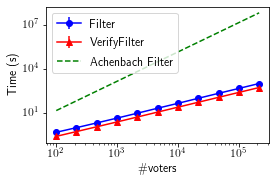

In [11]:
fig, ax = plt.subplots(figsize=(4,2.5))

colors = ('blue', 'red', 'green', 'cyan', 'magenta', 'yellow')
col = iter(colors)

x = [val[0] for val in full_filter["measurements"]]
filter_time = full_filter["FullFilter"]['means']
filter_time_err = full_filter["FullFilter"]['sems']
ax.errorbar(x, filter_time, yerr=filter_time_err, label="Filter", color="blue", fmt='o-')

filter_time_ver = full_filter_ver["FullFilter"]['means']
filter_time_ver_err = full_filter_ver["FullFilter"]['sems']
ax.errorbar(x, filter_time_ver, yerr=filter_time_ver_err, label="VerifyFilter", color="red", fmt='^-')

ax.errorbar(x, filter_achenbach, label="Achenbach Filter", color="green", fmt='--')

ax.set_ylabel('Time (s)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("\#voters")
ax.legend(loc=0)
# ax.xlim(1e4, 1e6)

plt.savefig("../figures/measured-cost.pdf", bbox_inches="tight")

## Estimating cost on Xeon machine
We use the above measured running times to estimate the cost on a 8x28 core Xeon machine, assuming a scaling factor of 170.

In [12]:
scale = 170

We first fit the measured data so we can use it in our computations.

In [13]:
fit = numpy.polyfit(x, filter_time, 1)
filter_time_fn = numpy.poly1d(fit)
fit = numpy.polyfit(x, filter_time_ver, 1)
filter_time_ver_fn = numpy.poly1d(fit)

And we plot the estimates in a graph for the paper.

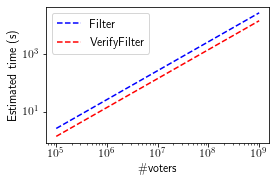

In [14]:
x = numpy.logspace(5, 9, num = 100)

fig, ax = plt.subplots(figsize=(4,2.5))

ax.errorbar(x, filter_time_fn(x) / scale, label="Filter", color="blue", fmt='--')
ax.errorbar(x, filter_time_ver_fn(x) / scale, label="VerifyFilter", color="red", fmt='--')

ax.set_ylabel('Estimated time (s)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("\#voters")
ax.legend(loc=0)

plt.savefig("../figures/estimated-cost.pdf", bbox_inches="tight")

## Graphs for ballot distribution

We start out by reading the data gathered, and parsing it

In [15]:
full_distr_raw = parse_csv('../data/distr/full_filter.csv')
full_distr_ver_raw = parse_csv('../data/distr/full_filter_ver.csv')

stats_raw = compute_stats(full_distr_raw, ["Nr_Voters","Total_Revotes","Extra_Padding"])
stats_ver_raw = compute_stats(full_distr_ver_raw, ["Nr_Voters","Total_Revotes","Extra_Padding"])

We now process the data we gathered to compute processing time per ballot. The experiments do not output the total number of balots, but instead output the number of boters (who each cast one ballot), the sum of revotes (by all voters together) and the extra ballots added by the TS (extra padding). We add these to get the total number of ballots.

In [16]:
total_ballots = numpy.array([ nv + tr + ep for (nv, tr, ep) in stats_raw['measurements']])
ballots_per_voter = total_ballots / numpy.array([nv for (nv, _, _) in stats_raw['measurements']])

total_time = (numpy.array(stats_raw['FullFilter']['means']) - numpy.array(stats_raw['Dummies']['means'])) / total_ballots
total_time_sem = numpy.array(stats_raw['FullFilter']['sems']) / total_ballots

total_time_ver = numpy.array(stats_ver_raw['FullFilter']['means']) / total_ballots
total_time_ver_sem = numpy.array(stats_raw['FullFilter']['sems']) / total_ballots

We now plot the data to produce the figure for the paper.

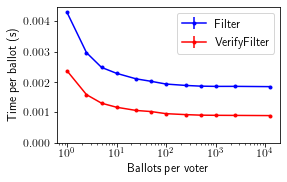

In [17]:
fig, ax = plt.subplots(figsize=(4,2.5))

colors = ('blue', 'red', 'green', 'cyan', 'magenta', 'yellow')
col = iter(colors)

ax.errorbar(ballots_per_voter, total_time, yerr=total_time_sem, label="Filter", color=next(col), fmt='.-')
ax.errorbar(ballots_per_voter, total_time_ver, yerr=total_time_ver_sem, label="VerifyFilter", color=next(col), fmt='.-')

ax.set_ylabel('Time per ballot (s)')
ax.set_xlabel('Ballots per voter')
ax.set_xscale('log')
ax.set_ylim(bottom=0)
ax.legend(loc=0)

plt.savefig("../figures/distr.pdf", bbox_inches="tight")

## Computing numbers used in the paper
We estimate computation time in several countries. We did not use these numbers.

In [18]:
print("Some data for specific countries:")
countries = {"France": 67372000, "Russia": 146877088, "Brazil": 204519000, "Brazil (registered)": 147305825}
for country, n in countries.items():
    t = filter_time_fn(n) / scale
    print("{}: {} s or {} min or {} hours".format(country, t, t / 60, t / 3600))
    


Some data for specific countries:
France: 1779.708644667099 s or 29.66181074445165 min or 0.49436351240752746 hours
Russia: 3879.9323405519162 s or 64.66553900919861 min or 1.0777589834866435 hours
Brazil: 5402.613624276894 s or 90.04356040461491 min or 1.5007260067435817 hours
Brazil (registered): 3891.2579503883903 s or 64.85429917313984 min or 1.0809049862189972 hours


### Computing cost for Iowa Caucasus
Used in the introduction.

In [19]:
def report_computation_time(number_ballots):
    number_operations = (number_ballots ** 2) * 29

    achenbach_time_seconds = GROUP_OPERATION_TIME * number_operations
    print("Achenbach time (days): ", achenbach_time_seconds / 86400)
    print("Achenbach time (months): ", achenbach_time_seconds / (86400 * 30))
    print("Achenbach time (years): ", achenbach_time_seconds / 31536000)

    voteagain_time_seconds = filter_time_fn(number_ballots)
    print("\nVoteAgain time (seconds)", voteagain_time_seconds)
    print("VoteAgain time (minutes)", voteagain_time_seconds / 60)

iowa_size = 176_574
print("## Iowa Caucus ({} voters) ##".format(iowa_size))        
report_computation_time(iowa_size)

small_town = 100_000
print("\n\n## Small Town ({} voters) ##".format(small_town))        
report_computation_time(small_town)

## Iowa Caucus (176574 voters) ##
Achenbach time (days):  497.67451757105914
Achenbach time (months):  16.589150585701972
Achenbach time (years):  1.3634918289618059

VoteAgain time (seconds) 792.1417509585527
VoteAgain time (minutes) 13.20236251597588


## Small Town (100000 voters) ##
Achenbach time (days):  159.62168587962964
Achenbach time (months):  5.320722862654321
Achenbach time (years):  0.43731968734145105

VoteAgain time (seconds) 448.2665265317051
VoteAgain time (minutes) 7.4711087755284185


### Computing cost for a large City

In [20]:
def report_computation_time_server(number_ballots):
    number_operations = (number_ballots ** 2) * 29

    achenbach_time_seconds = (GROUP_OPERATION_TIME * number_operations) / scale
    print("Achenbach time (days): ", achenbach_time_seconds / 86400)
    print("Achenbach time (months): ", achenbach_time_seconds / (86400 * 30))
    print("Achenbach time (years): ", achenbach_time_seconds / 31536000)

    voteagain_time_seconds = filter_time_fn(number_ballots) / scale
    print("\nVoteAgain time (seconds)", voteagain_time_seconds)
    print("VoteAgain time (minutes)", voteagain_time_seconds / 60)

big_town = 1_000_000
print("## Large City ({} voters) ##".format(big_town))        
report_computation_time_server(big_town)

## Large City (1000000 voters) ##
Achenbach time (days):  93.89510934095861
Achenbach time (months):  3.1298369780319537
Achenbach time (years):  0.2572468749067359

VoteAgain time (seconds) 26.411457658551107
VoteAgain time (minutes) 0.4401909609758518


### Time for Brazilian election
We first compute the time to filter the Brazilian election assuming no revotes, and 147M voters.

In [21]:
number_voters = 147_000_000
time = filter_time_fn(number_voters) / scale
print("Brazilian elections (147M voters, no revoting): {} minutes".format(time / 60))

Brazilian elections (147M voters, no revoting): 64.7196535112601 minutes


Next, we assume revoting, with a maximum of 50% (i.e., at most 147M/2 extra ballots) and a maximum rate of 1/10 seconds.

In [22]:
number_ballots = number_voters * 10 # Using the x10 numbers from the graphs
time = filter_time_fn(number_ballots) / scale
print("Brazilian elections (147M voters, no revoting): {} hours".format(time / 3600))

Brazilian elections (147M voters, no revoting): 10.786620818113018 hours


# Mix and decrypt times
First, we read the data gathered and parsing it.

In [23]:
mix_raw = parse_csv('../data/mix/mix_and_decrypt.csv')
mix_stats_raw = compute_stats(mix_raw, ["NumberCiphertexts"])

The experiment separately measures the time to do a verifiable proof and to do a verifiable decryption. Therefore we add the corresponding numbers. For convenience, we plot the result. We do not use this plot in the paper.

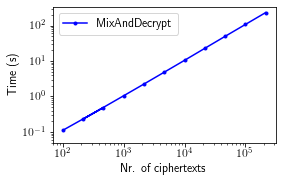

In [24]:
nr_ciphertexts = [v[0] for v in mix_stats_raw["measurements"]]
mix_dec_time = numpy.array(mix_stats_raw["ShuffleAndProofTime"]["means"]) + numpy.array(mix_stats_raw["DecryptAndProofTime"]["means"])

fig, ax = plt.subplots(figsize=(4,2.5))

colors = ('blue', 'red', 'green', 'cyan', 'magenta', 'yellow')
col = iter(colors)

ax.errorbar(nr_ciphertexts, mix_dec_time, label="MixAndDecrypt", color=next(col), fmt='.-')

ax.set_ylabel('Time (s)')
ax.set_xlabel('Nr. of ciphertexts')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(bottom=0.05)
ax.legend(loc=0)

We use the measurements to fit an estimate. We use this estimate to compute the numbers used in the paper.

In [25]:
# Fit MixAndDecrypt time
fit = numpy.polyfit(nr_ciphertexts, mix_dec_time, 1)
mix_dec_time_fn = numpy.poly1d(fit)

print("Time to mix+decrypt 100,000 ballots is {} seconds".format(mix_dec_time_fn(100_000)))

time1M = mix_dec_time_fn( 1_000_000 ) / scale
print("Time to mix+decrypt 1M ballots on server is {} seconds".format(time1M))

Time to mix+decrypt 100,000 ballots is 108.24603907055227 seconds
Time to mix+decrypt 1M ballots on server is 6.377784513661916 seconds
